In [818]:
import pandas as pd
import matplotlib as pl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from scipy.stats import norm, skew
from scipy import stats
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Resumo e objetivos

Essa análise foi desenvolvida pelo aluno Lucas Rolim como parte da disciplina de Introdução ao Aprendizado de Máquina *(EEL891)* ofertada pelo Departamento de Eletrônica da Universidade Federal do Rio de Janeiro em 2018.2.

O objetivo do trabalho é desenvolver um modelo capaz de prever o preço de imóveis na cidade de Recife. Para tal será utilizado o conjunto de dados fornecido no desafio do Kaggle da matéria e também um conjunto de dados minerado da web sobre distribuição de renda nos bairros da cidade.

Será posto a prova o desemprenho da maior parte de modelos de regressão disponíveis na biblioteca scikit-learn, bem como modelos externos como LGBM e xGBoost.

## Conjuntos de dados

O conjunto de dados utilizado é referente a dados minerados de anúncios online de venda imóveis na cidade pernambucana de Recife. O conjunto foi disponibilizado no desafio da disciplina DEL/UFRJ - EEL891. 

In [819]:
df_train = pd.read_csv("data/train.csv",sep=',')
df_test = pd.read_csv("data/test.csv",sep=',')

# salvamos os ids do conjunto de testes para adicionar posteiromente em nosso dataset de submissão para o Kaggle
# além disso adicionamos uma coluna temporária de preço no conjunto de testes, de modo a o deixar com a mesma
# dimensão do conjunto de treino, facilitando assim transformações nesses dados

test_ids = df_test['Id']
df_test['preco'] = None

train_size = len(df_train)
df_train.head(3)

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,2000,Casa,Imbiribeira,Imobiliaria,3,3,5,223,167,piscina e copa,...,0,1,0,0,0,0,0,0,0,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,3,1,0,53,0,nenhum,...,0,0,0,0,0,0,0,0,0,450000.0


Através da matriz de correlação somos capazes de notar uma alta correlação entre a variável *¨quartos¨* e as demais, bem como uma forte relação entre as variáveis *¨piscina¨* e *¨churrasqueira¨*. Essas variáveis, portanto, serão desconsideradas em nosso modelo.

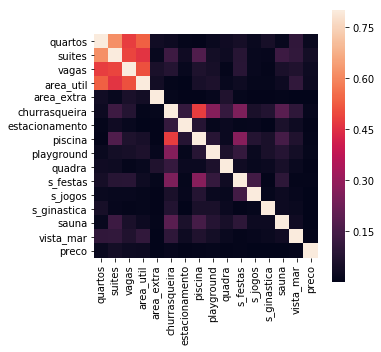

In [820]:
corrmat = abs(df_train.drop('Id', axis = 1).corr())
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

Além do conjunto de treino fornecido no desafio, será utilizado também um conjunto de informações complemetares, disponibilizadas publicamente pelo governo de Pernambuco no site do [Banco de dados do Estado](http://www.bde.pe.gov.br/visualizacao/Visualizacao_formato2.aspx?CodInformacao=1162&Cod=3). Essas informações são referentes a distribuição de renda média dentro de cada um dos bairros da cidade de Recife e foram coletados no ano de 2010.

In [821]:
neighborhood_income = pd.read_csv("data/renda_bairros.csv",sep=',')

# dados faltantes significam que não foram encontaradas pessoas em uma faixa de renda em certo bairro
neighborhood_income.iloc[:,2:] = neighborhood_income.iloc[:,1:].fillna(0)

# convertemos o número absoluto de pessoas em cada faixa de renda para uma porcentagem relativa ao tamanho do bairro
# dessa forma evitamos distorções causadas por disparidades no tamanho da população de cada bairro
neighborhood_income.iloc[:, 2:] = neighborhood_income.iloc[:, 2:].divide(neighborhood_income.iloc[:,1], axis = 'rows')

neighborhood_income = neighborhood_income.drop(columns=['Total ¹'])
neighborhood_income.head(3)

,bairro,Até 1/2 salário mínimo,Mais de 1/2 a 1 salário mínimo,Mais de 1 a 2 salários mínimos,Mais de 2 a 5 salários mínimos,Mais de 5 a 10 salários mínimos,Mais de 10 a 20 salários mínimos,Mais de 20 salários mínimos,Sem rendimento
0,Aflitos,0.002581,0.012390,0.026846,0.094476,0.223542,0.308725,0.273619,0.057821
1,Afogados,0.036308,0.194274,0.253974,0.301842,0.114884,0.033779,0.006954,0.057984
2,Agua Fria,0.055393,0.219538,0.296974,0.285993,0.070360,0.013584,0.002603,0.055556


Fazendo uma matriz de correlação desses dados notamos uma alta relação entre quase todas as variáveis. Sendo assim, temos um indicativo de que talvez seja mais vantajoso selecionar apenas algumas dessas colunas para agregar em nosso conjunto de dados inicial.

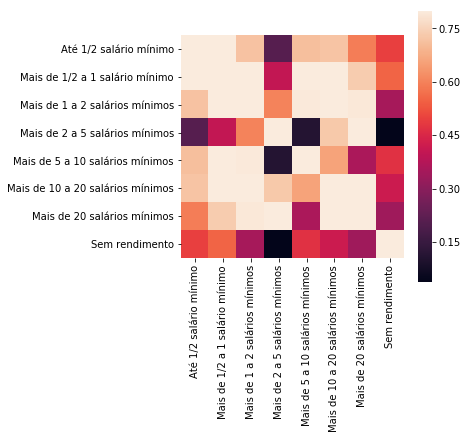

In [822]:
corrmat = abs(neighborhood_income.corr())
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

Vamos remover faixas de renda com alta correlação entre si e verificar o resultado:

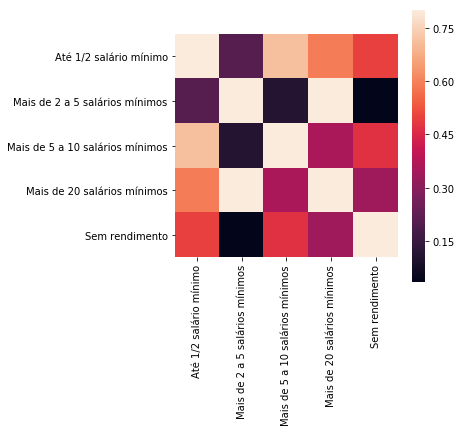

In [823]:
neighborhood_income = neighborhood_income.drop(columns=['Mais de 1/2 a 1 salário mínimo',
                                 'Mais de 1 a 2 salários mínimos',
                                 'Mais de 10 a 20 salários mínimos'
                                 ])

corrmat = abs(neighborhood_income.corr())
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

## Pré processamento dos dados

Unificaremos agora os dados de treino e testes para aplicar as transformações necessárias e tornaremos a separar esses dados antes de realizar o treinamento dos modelos.

In [824]:
df = pd.concat((df_train, df_test))
df = df.drop(columns=['churrasqueira','quartos','tipo_vendedor'])

### Agregação de dados de distribuição de renda

Como forma de enriquecer o conjunto de treino, adicionamos 5 novas colunas referentes a distribuição de renda nos bairros. Alguns dos bairros presentes no conjunto de treino não são de fato bairros da cidade de Recife, mas sim pontos de referência ou subregiões. Nesses casos preencheremos essas linhas com uma distribuição uniforme de renda.

In [825]:
# adicionamos novas colunas vazias no dataset
income_columns = ['meio_1_salario','2_5_salarios','5_10_salarios','20_salarios','sem_salario']
df = pd.concat([df, df.reindex(columns = income_columns)], axis = 1)

# tratamos dados que não são bairros de fato
all_neighborhood = list(df.bairro.unique())

skip_neighborhood = ['Beira Rio', 'Centro']
neighborhood = list(set(all_neighborhood).symmetric_difference(skip_neighborhood))

df.loc[df.bairro == 'Beira Rio', income_columns] = 1/len(income_columns)
df.loc[df.bairro == 'Centro', income_columns] = 1/len(income_columns)

# agergamos ao dataset os dados do conjunto de dados de renda média por bairro
for neighborhood_name in neighborhood:
        df.loc[df.bairro == neighborhood_name, income_columns] = neighborhood_income[neighborhood_income['bairro'] == neighborhood_name].iloc[:,1:].values

df.head(3)

,Id,tipo,bairro,suites,vagas,area_util,area_extra,diferenciais,estacionamento,piscina,...,s_jogos,s_ginastica,sauna,vista_mar,preco,meio_1_salario,2_5_salarios,5_10_salarios,20_salarios,sem_salario
0,2000,Casa,Imbiribeira,3,5,223,167,piscina e copa,0,1,...,0,0,0,0,1e+06,0.041486,0.281916,0.154787,0.017770,0.040884
1,2001,Apartamento,Casa Amarela,4,2,157,0,piscina e churrasqueira,0,1,...,0,0,0,0,680000,0.012156,0.269471,0.188038,0.101764,0.032272
2,2002,Apartamento,Encruzilhada,1,0,53,0,nenhum,0,0,...,0,0,0,0,450000,0.003992,0.208084,0.285180,0.147455,0.012725


### Binarização de variáveis

Aplicaremos a técnica de **one hot encoding** para binarizar o bairro de cada imóvel. Logo, cada um desses bairros se tornará uma coluna binária que em cada linha terá valor 1 para um dos bairros e zero para todos os demais.

In [826]:
hot_columns = pd.get_dummies(df['bairro'], prefix= 'bairro')
df = pd.concat([df, hot_columns], axis = 1)
df = df.drop(columns=['bairro'])

## Transformação variáveis numéricas

Em primeiro lugar iremos substituir os valores categóricos do tipo de imóvel por um mapeamento numérico que possui em si conhecimento implícito sobre o domínio do problema. Por exemplo, atribuiremos em nosso mapeamento valores maiores para casas e apartamentos do que para quitinetes e lofts.

In [827]:
type_value = {"Apartamento": 3, "Casa": 3, "Quitinete": 1, "Loft": 2}
df = df.replace({"tipo": type_value})

Para reduzir a assimetria entre os valores das variáveis numéricas nós aplicamos a transformação **Min-Max**.

In [828]:
from sklearn.preprocessing import minmax_scale

cols = ['area_util','suites','vagas','suites','area_extra']

df[cols] = minmax_scale(df[cols])

Removermos a coluna *¨diferenciais¨*, que já teve suas informações codificadas em outras colunas, e a coluna Id.

In [829]:
df = df.drop(columns=['Id','diferenciais'])

Agora que realizamos todas as transformações comuns ao conjunto de treino e de teste, tornaremos a separá-los em duas variáveis distintas.

In [830]:
df_test = df.iloc[train_size:,:]
df_test = df_test.drop(columns=['preco'])
df = df.iloc[:train_size,:]
df = df.convert_objects(convert_numeric=True)

In [831]:
train_size

4683

In [832]:
len(df)

4683

## Transformação da variável alvo para distribuição normal

Os preços de imóveis tendem a ter uma distribuição de cauda pesada, o que não é o mais adequado para a aplicação de modelos de regressão. Aplicaremos a transformação **log1p** do scikit-learn para aproximar essa distribuição de uma normal e assim melhorar eficiência dos modelos de regressão.

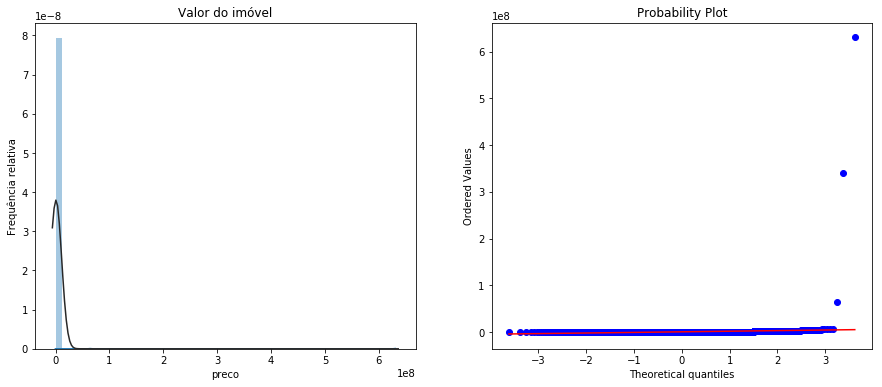

In [833]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(df['preco'], fit = norm, ax = axes[0]);
(mu, sigma) = norm.fit(df['preco'])

axes[0].set_ylabel('Frequência relativa')
axes[0].set_title('Valor do imóvel')


stats.probplot(df['preco'], plot = axes[1])
plt.show()

Verificamos então como ficam os dados após a transformação:

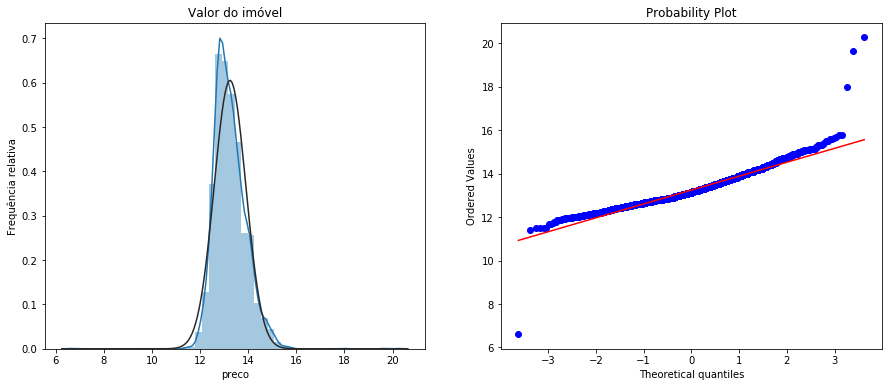

In [834]:
# aplicação da transformação
df['preco'] = np.log1p(df['preco'])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(df['preco'], fit = norm, ax = axes[0]);
(mu, sigma) = norm.fit(df['preco'])

axes[0].set_ylabel('Frequência relativa')
axes[0].set_title('Valor do imóvel')


stats.probplot(df['preco'], plot = axes[1])
plt.show()

### Remoção de outliers

O conjunto de dados possui 3 variáveis contínuas com grande variância, são elas: preço do imóvel, área útil e área extra. Através da plotagem do boxplot é possível verificar que existem outliers em todas essas variáveis, o que pode atrapalhar de maneira significativa o desempenho de modelos de regressão.

Sendo assim, a primeira etapa de pré processamente dos dados será a remoção das linhas em que umas dessas três variáveis é outlier. Removeremos 

4683 linhas no dataset


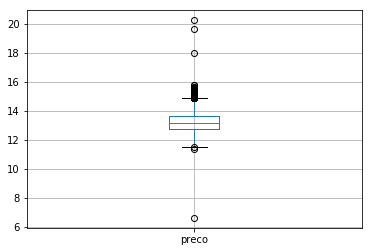

In [835]:
df.boxplot(column = ['preco'])
original_size = len(df)
print("{} linhas no dataset".format(train_size))

4302 linhas no dataset
Diminuição de 8.14% no tamanho do conjunto de treino


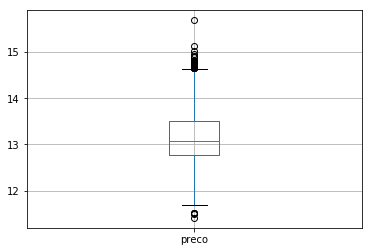

In [836]:
columns = ['preco','area_extra','area_util']

for column in columns:
    df = df[np.abs(df_train[column] - df_train[column].mean()) <= (1 * df_train[column].std())]

df = df[df.preco > 10]

df.boxplot(column = ['preco'])

print("{} linhas no dataset".format(len(df['preco'])))
redu = round(((original_size - len(df))/original_size)* 100,2)
print("Diminuição de {}% no tamanho do conjunto de treino".format(redu))

Por fim, separamos o conjunto de treino em duas variáveis, uma referêntes aos parâmetros X para treinar ao modelo e outra referente ao ¨gabarito¨ Y.

In [837]:
target = df['preco']
parameters = df.copy().drop(columns=['preco'])

## Modelos

Testaremos agora o desempenho de diferentes modelos de regressão na tarefa de predição do preço de imóveis. Foi dada prioridade na utilização dos modelos estudados na matéria *EEL891*, como forma de explorar os conceitos teóricos abordados em aula a sermos capazes de nos aprofundar nos ajustes finos e parametrizações disponíveis em cada um desses modelos.

Os modelos de predição testados foram:

- Regressão polinomial
- Regressão Ridge
- Regressão Lasso
- Elastic Net
- Ridge bayessiano
- Florestas aleatórias
- LGBM
- xgBoost

### Validação dos modelos

Para a validação dos modelos treinados será utilizada a técnica de **validação cruzada**. A cada modelo serão feitas 5 execuções com validação cruzada e calculada a média dos resultados. A métrica de erro utilizada, como sugerido no desafio, será o **RMSPE**.

In [838]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

# número de folds na validação cruzadas
cv_number = 5

# função RMSPE a ser utilizada como métrica de erro
def rmspe(y_pred, y):
    rmspe = np.sqrt(np.mean( (1/ y**2) * (y_pred - y)**2 ))
    return rmspe

rmspe_score = make_scorer(rmspe, greater_is_better=False)

## dataset para armazenar o resultado dos modelos
results = pd.DataFrame([], columns = ['mean', 'std'])

### Regressão polinomial

In [839]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline

polynomial = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear',linear_model.LinearRegression(copy_X =  True))]) 

scores = cross_val_score(polynomial,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = 2)

results.loc['Polynomial'] = [-scores.mean(), scores.std()]

### Ridge Regression

Melhor resultado obtido com alpha = 0.0050040080160320645, resultado obtido: 0.018744192659239912


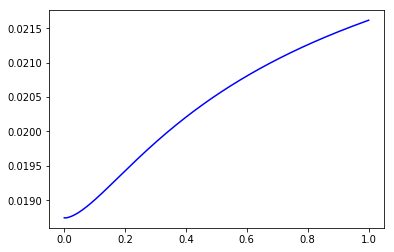

In [840]:
from sklearn.preprocessing import PolynomialFeatures

# iteramos em um intervalo de alpha que pensamos ser o mais proveitoso, de forma a achar o alpha ótimo ou ao menos um
# mínimo local

ridge_alpha_tunning = []

domain = list(np.linspace(0.001,1,500))
for alpha_value in domain:    
    ridge = linear_model.Ridge(alpha = alpha_value, max_iter = 1000, random_state = 161095)
    scores = cross_val_score(ridge,
                             parameters,
                             target,
                             scoring = rmspe_score,
                             cv = cv_number)
    ridge_alpha_tunning.append(-np.mean(scores))

# removemos alhpas muito grandes (em alguns casos descontinuidades) para facilitar a plotagem dos resultados
while max(ridge_alpha_tunning) > 1:
        index  = ridge_alpha_tunning.index(max(ridge_alpha_tunning))
        del domain[index]
#         del ridge_alpha_tunning[index]
        
best_alpha = domain[ridge_alpha_tunning.index(min(ridge_alpha_tunning))]
ridge = linear_model.Ridge(alpha = best_alpha, max_iter = 1000, random_state = 161095)
scores = cross_val_score(ridge,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

# salvamos o resultado do melhor alpha em nosso dataframe de resultados
results.loc['Ridge'] = [-scores.mean(), scores.std()]

print("Melhor resultado obtido com alpha = {}, resultado obtido: {}".format(best_alpha, min(ridge_alpha_tunning)))

plt.plot(domain, ridge_alpha_tunning, color='b')

### Lasso regression

Melhor resultado obtido com alpha = 5.0040080160320644e-05, resultado obtido: 0.018684852225104617


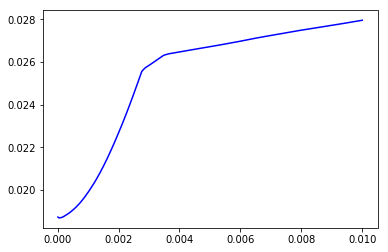

In [841]:
lasso_alpha_tunning = []
domain = list(np.linspace(0.00001,0.01,500))
for alpha_value in domain:    
    lasso = linear_model.Lasso(alpha = alpha_value,random_state = 161095)
    scores = cross_val_score(lasso,
                             parameters,
                             target,
                             scoring = rmspe_score,
                            cv = cv_number)
    lasso_alpha_tunning.append(-np.mean(scores))


while max(lasso_alpha_tunning) > 1:
        index  = lasso_alpha_tunning.index(max(lasso_alpha_tunning))
        del domain[index]
        del lasso_alpha_tunning[index]
        
best_alpha = domain[lasso_alpha_tunning.index(min(lasso_alpha_tunning))]
lasso = linear_model.Lasso(alpha = alpha_value,random_state = 161095, max_iter = 3000)
scores = cross_val_score(lasso,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['Lasoo'] = [-scores.mean(), scores.std()]

print("Melhor resultado obtido com alpha = {}, resultado obtido: {}".format(domain[lasso_alpha_tunning.index(min(lasso_alpha_tunning))],min(lasso_alpha_tunning)))
plt.plot(domain, lasso_alpha_tunning, color='b')

### Elastic Net

Melhor resultado obtido com alpha = 1e-06, resultado obtido: 0.018748997576900524


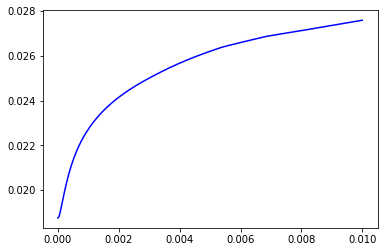

In [842]:
from sklearn.linear_model import ElasticNet

elastic_alpha_tunning = []
domain = list(np.linspace(0.000001,0.01,500))
for alpha_value in domain:    
    elastic_net = ElasticNet(alpha = alpha_value, l1_ratio= 0.6, copy_X = True,random_state = 161095)
    scores = cross_val_score(elastic_net,
                             parameters,
                             target,
                             scoring = rmspe_score,
                             cv = cv_number)
    elastic_alpha_tunning.append(-np.mean(scores))


while max(elastic_alpha_tunning) > 1:
        index  = elastic_alpha_tunning.index(max(elastic_alpha_tunning))
        del domain[index]
        del elastic_alpha_tunning[index]
        
best_alpha = domain[elastic_alpha_tunning.index(min(elastic_alpha_tunning))]
elastic_net = ElasticNet(alpha = alpha_value, l1_ratio= 0.6, copy_X = True,random_state = 161095)
scores = cross_val_score(elastic_net,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['ElasticNet'] = [-scores.mean(), scores.std()]
        
print("Melhor resultado obtido com alpha = {}, resultado obtido: {}".format(domain[elastic_alpha_tunning.index(min(elastic_alpha_tunning))],min(elastic_alpha_tunning)))
plt.plot(domain, elastic_alpha_tunning, color='b')

### Bayesian Ridge

In [843]:
from sklearn.linear_model import BayesianRidge

bayesian_ridge = BayesianRidge()

scores = cross_val_score(bayesian_ridge,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['BayesianRidge'] = [-scores.mean(), scores.std()]

### Random Forest

In [844]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators = 100)

scores = cross_val_score(random_forest,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['RandomForest'] = [-scores.mean(), scores.std()]

### LightGBM

In [845]:
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate = 0.1, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf = 60, min_sum_hessian_in_leaf = 10)

scores = cross_val_score(lgbm,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = 20)

print(-scores.mean())
results.loc['LGBM'] = [-scores.mean(), scores.std()]

0.016939849474754916


### KNN

In [846]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

scores = cross_val_score(knn,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['KNeighbors'] = [-scores.mean(), scores.std()]

### xgBoost

In [847]:
import xgboost as xgb

xgboost = xgb.XGBRegressor(colsample_bytree = 0.6,
                           gamma = 0.2,
                           learning_rate = 0.04,
                           max_depth = 4,
                           min_child_weight = 1.5,
                           n_estimators = 2200,
                           reg_alpha = 0.9,
                           reg_lambda = 0.1,
                           subsample = 0.7,
                           silent = 1,
                           random_state = 161095,
                           n_jobs = 4)

scores = cross_val_score(xgboost,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = 5)

results.loc['xgBoost'] = [-scores.mean(), scores.std()]

print(-scores.mean())

0.01658929773370053


In [848]:
results

,mean,std
Polynomial,0.255948,0.017650
Ridge,0.018744,0.000475
Lasoo,0.027953,0.000556
ElasticNet,0.027592,0.000529
BayesianRidge,0.018751,0.000484
RandomForest,0.017103,0.000692
LGBM,0.016940,0.001689
KNeighbors,0.023782,0.000740
xgBoost,0.016589,0.000486


## Conclusões e submissões



Foi possível concluir que **modelos de Ensemble são os que apresentam melhor resultado**. As variações LGBM e xGBoost do modelo Gradient Boost obtiveram os melhores resultados em especial. Ambos os modelos funcionam com base em árvores de decisão e implementam técnicas que constroem diversas árvores para mesclar os resultados e reduzir o overfitting.

Notou-se também que a etapa que mais surtiu efeito no resultado dos modelos foi o pré processamento dos dados. Mudanças nessas etapa tenderam a surtir muito mais efeito do que ajustes finos nos parâmetros de qualquer um dos modelos utilizados.

### Gerador de arquivo de submissão

Observamos os resultados do de nossa análise e escolhemos o modelo **xgBoost** para treinar com os dados de teste e realizar a submissão para o Kaggle.

In [850]:
result = pd.DataFrame()
result['Id'] = test_ids

xgboost = xgb.XGBRegressor(colsample_bytree = 0.6,
                           gamma = 0.2,
                           learning_rate = 0.04,
                           max_depth = 4,
                           min_child_weight = 1.5,
                           n_estimators = 2200,
                           reg_alpha = 0.9,
                           reg_lambda = 0.1,
                           subsample = 0.7,
                           silent = 1,
                           random_state = 161095,
                           n_jobs = 4)

xgboost.fit(parameters, target)
xgboost_predictions = xgboost.predict(df_test)

transform_predict = np.expm1(xgboost_predictions)
result['preco'] = transform_predict
result.to_csv('submission.csv', index=False)